In [1]:
from imutils.video import VideoStream
from imutils import face_utils
from pygame import mixer
mixer.init()

import imutils
import matplotlib.pyplot as plt
import numpy as np
import time
import dlib
import cv2

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## 使用將Dlib彙整的imutils
* 使用 imutils 內的 face_utils 之 FACIAL_LANDMARKS_IDXS，詳細參數為下表：
* 繪製左眼與右眼座標,確認0至5的索引位置
<img src="https://raw.githubusercontent.com/j82887/Face-Detection/master/00_Image/Dlib%20and%20Imutils.png" width="300">


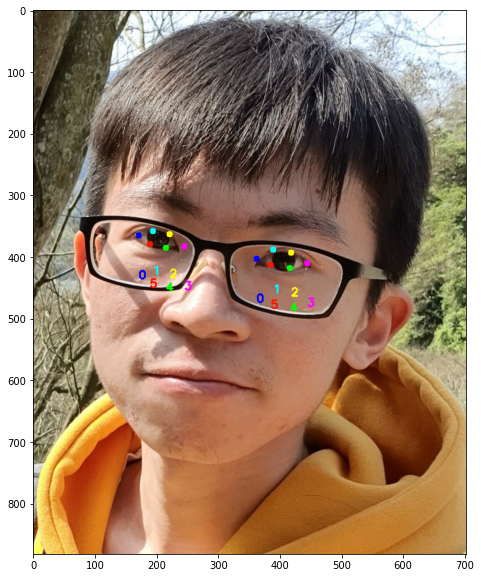

In [2]:
img = cv2.imread("Image_test/Face_test4.jpeg")

detector=dlib.get_frontal_face_detector()
predictor=dlib.shape_predictor("Model/shape_predictor_68_face_landmarks.dat")

(left_Start,left_End)=face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(right_Start,right_End)=face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

face = detector(img, 0)
shape = predictor(img, face[0]) 
shape = face_utils.shape_to_np(shape)  

colors = [(255,0,0),(255,255,0),(0,255,255),(255,0,255),(0,255,0),(0,20,255)]

leftEye = shape[left_Start:left_End]
for i in range(len(leftEye)):
    cv2.putText(img, "%d" %(i), (leftEye[i][0], leftEye[i][1]+70),cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors[i], 2)      
    cv2.circle(img, (leftEye[i][0], leftEye[i][1]), 5, colors[i], -1)

rightEye = shape[right_Start:right_End]    
for i in range(len(rightEye)):
    cv2.putText(img, "%d" %(i), (rightEye[i][0], rightEye[i][1]+70),cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors[i], 2)      
    cv2.circle(img, (rightEye[i][0], rightEye[i][1]), 5, colors[i], -1)
    
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 建立 eyesRatio 方法，以計算眼睛的高寬比
* 使用numpy中的linalg.norm範數，計算高與寬：
* 單隻眼睛高有兩組為索引1,5與2,4
* 單隻眼睛寬有一組為索引0,3
* 回傳兩高相加與兩倍寬的比例，若眼睛張開則數值越高，眼睛閉起來則數值越低

In [3]:
#計算眼睛的高寬比
def eyesRatio(eye):
    
    # 計算兩點距離（即兩點向量之範數）
    hight1 = np.linalg.norm(eye[1] - eye[5])
    hight2 = np.linalg.norm(eye[2] - eye[4])
    width = np.linalg.norm(eye[0] - eye[3])
    
    # 回傳高寬比
    return (hight1+hight2) / (2.0*width)

## 設定參數初始值

In [4]:
# 眼睛寬高比的臨界值，由前30張圖像平均而得
eyesRatioLimit=0  
# 數據採集的計數，採集30次然後取平均值
collectCount=0  
# 用於數據採集的求和
collectSum=0  
# 是否開始檢測
startCheck=False  
# 統計"閉眼"的次數
eyesCloseCount=0  
# 統計"閉眼"的次數
eyesOpenCount=0 

## 打瞌睡偵測提醒

* 匯入人臉辨識器與特徵器
* 使用 imutils 內的 face_utils 之 FACIAL_LANDMARKS_IDXS 來獲取兩眼的索引值
* 開啟攝影機並延遲兩秒
* 影像改為寬720
* 人臉檢測與人臉特徵檢測，並其位置轉為陣列，根據索引值來獲得左右眼位置的陣列
* 計算左右眼高寬比，並根據位置畫出凸殼輪廓
* 計算兩眼平均高寬比
* 以collectCount條件式來累計前三十次畫面的平均高寬比
* 三十次後startCheck改為True，將計算eyesRatioLimit即前三十次畫面的總平均高寬比
    * 若當前眼睛長寬比大於前三十次畫面的總平均高寬比，則eyesCloseCount計數加一，eyesOpenCount計數重置為零
        * 若eyesCloseCount計數至三十（含）以上，則顯示睡著與播放聲音
    * 若當前眼睛長寬比小於等於前三十次畫面的總平均高寬比，則eyesCloseCount計數重置為零，eyesOpenCount計數加一
    * 顯示目前眼睛高寬比
    * 顯示開始畫面三十張平均之眼睛平均寬高比
    * 顯示閉眼次數

In [ ]:
# 匯入人臉辨識器
detector=dlib.get_frontal_face_detector()

# 匯入人臉特徵器
predictor=dlib.shape_predictor("Model/shape_predictor_68_face_landmarks.dat")

# 左右眼索引
(left_Start,left_End)=face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(right_Start,right_End)=face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# 開啟攝影機，延遲2秒鐘
vsThread=VideoStream(src=0).start()
time.sleep(2.0)

# 循環檢測
while True:
    frame = vsThread.read()
    frame = imutils.resize(frame, width=720)
    faces = detector(frame, 0)  
    
    for face in faces:
        
        # 人臉特徵位置
        shape = predictor(frame, face) 
        
        # 轉為陣列
        shape = face_utils.shape_to_np(shape)  
        
        # 左右眼位置
        leftEye = shape[left_Start:left_End]
        rightEye = shape[right_Start:right_End]
        
        # 左右眼寬高比
        leftEyesVal = eyesRatio(leftEye)
        rightEyesVal = eyesRatio(rightEye)
        
        # 凸殼
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        
        #繪製輪廓
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        
        #取兩隻眼長寬比的的平均值
        eyeRatioVal = (leftEyesVal + rightEyesVal) / 2.0 
        
        #計算30次平均值
        if collectCount<30:
            collectCount+=1
            collectSum+=eyeRatioVal
            startCheck=False
        else:
            if not startCheck:
                eyesRatioLimit=collectSum/(1.0*30)
            startCheck=True

        if startCheck:
            
            #如果眼睛長寬比大於之前檢測到的臨界值，則計數
            if eyeRatioVal < eyesRatioLimit:  
                eyesCloseCount += 1
                eyesOpenCount = 0
                
                #次數超過設定值
                if eyesCloseCount >= 30:  
                    cv2.putText(frame, "SLEEP!!!", (580, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                    #發出聲音
                    mixer.music.load('Image_test/bb.wav')
                    mixer.music.play()  
            else: 
                eyesOpenCount += 1
                if eyesOpenCount > 2:
                    eyesCloseCount = 0
            
            # 目前眼睛高寬比
            cv2.putText(frame, "Now Eyes Ratio: {:.3f}".format(eyeRatioVal), (20, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (18,153,255), 2)
            
            # 開始畫面三十張平均之眼睛平均寬高比
            cv2.putText(frame, "Th Eyes Ratio: {:.3f}".format(eyesRatioLimit), (20, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (18,153,255), 2)
            
            # 閉眼次數
            cv2.putText(frame,"Eyes Colse: {}".format(eyesCloseCount), (320,30),cv2.FONT_HERSHEY_SIMPLEX, 0.6,(18,153,255),2)

    cv2.imshow("Frame", frame)
    if cv2.waitKey(10) == 27:  break

cv2.destroyAllWindows()
vsThread.stop()